In [31]:
# |default_exp datasets

In [37]:
# |export
import math
from itertools import zip_longest

import numpy as np
import matplotlib.pyplot as plt
import fastcore.all as fc

# Hugging Face datasets

A whole bunch of different dataets to play with. Huggingface hub - models and dataests. Load from hub.

In [8]:
# Ada dataset_build contains a bunch of metadata about the dataset
from datasets import load_dataset_builder

name = "fashion_mnist"
ds_builder = load_dataset_builder(name)

print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [9]:
# What features does the dataset have
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [10]:
# Are there any recommended training/test splits
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296655, num_examples=60000, shard_lengths=None, dataset_name=None),
 'test': SplitInfo(name='test', num_bytes=5233818, num_examples=10000, shard_lengths=None, dataset_name=None)}

In [15]:
# Load the dataset itself rather than the metadata
from datasets import load_dataset

dataset_dict = load_dataset(name)

# The dict contains train and test splits
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [17]:
train_ds, test_ds = dataset_dict["train"], dataset_dict["test"]

train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [19]:
# We can look at an items image
train_ds[0]["image"]

In [20]:
# And its label
train_ds[0]["label"]

9

In [26]:
# And get the text for the label
train_ds.features["label"].int2str([train_ds[0]["label"]])

['Ankle boot']

In [47]:
# Lets make a DataLoader
import torch
from torch import tensor
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF


# We're given an array where each item is an image/label dict
# We output a single dict where image contains all images and label contains all labels
def collate_fn(items):
    return {
        "image": torch.stack([TF.to_tensor(item["image"]) for item in items]),
        "label": tensor([item["label"] for item in items]),
    }


dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=16)

batch = next(iter(dl))
batch["image"].shape, batch["label"].shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [52]:
# Above we are using the collate_fn to transofrm the image into a tensor, we could use with_transform instead
def transforms(items):
    items["image"] = [TF.to_tensor(img) for img in items["image"]]
    return items


# Our dataloader will now use the default collate function with our transformed data
# The default collate func already knows how to collate dicts of tensors
trans_data = train_ds.with_transform(transforms)
dl = DataLoader(trans_data, batch_size=16)

batch = next(iter(dl))
batch["image"].shape, batch["label"].shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [62]:
# If you want to do the transform in place the you could make an @inplace decorator
def inplace(f):
    def _f(b):
        f(b)
        return b

    return _f


# Here we also flatten the image tensor
@inplace
def transformi(items):
    items["image"] = items["image"] = [torch.flatten(TF.to_tensor(img)) for img in items["image"]]


trans_flat_data = train_ds.with_transform(transformi)

flat_dl = DataLoader(trans_flat_data, batch_size=16)

flat_batch = next(iter(flat_dl))
flat_batch["image"].shape, flat_batch["label"].shape

(torch.Size([16, 784]), torch.Size([16]))

In [65]:
# itemgetter creates a func that gets the specified keys from a dict
from operator import itemgetter

d = dict(a=1, b=2, c=3)
ig = itemgetter("a", "c")

ig(d)

(1, 3)

In [69]:
from torch.utils.data import default_collate

# pytorch's default collate, when given dicts, takes matching keys and stacks their values together
batch = dict(a=[1], b=[2]), dict(a=[3], b=[4])
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

In [74]:
# We can write a collating func that uses itemgetter to get the features of a HF dataset that we want
def collate_dict(dataset):
    get = itemgetter(*dataset.features)

    def _f(items):
        return get(default_collate(items))

    return _f


# Now instead of a dict we get tuples, HF tends to use dicts but a lot of things want tuples
dlf = DataLoader(trans_flat_data, batch_size=16, collate_fn=collate_dict(trans_flat_data))
dlf_batch = next(iter(dlf))

dlf_batch, dlf_batch[0].shape, dlf_batch[1].shape

((tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])),
 torch.Size([16, 784]),
 torch.Size([16]))

## Plotting images

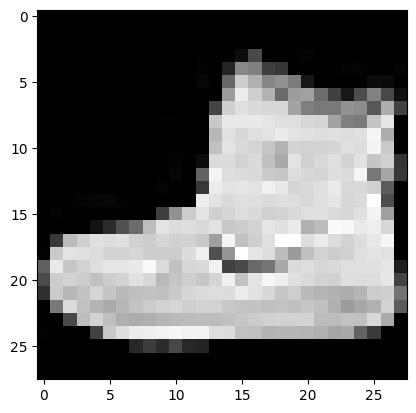

In [114]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["image.cmap"] = "gray"

batch = next(iter(dl))
images = batch["image"]

plt.imshow(images[0][0])

In [40]:
# |export


@fc.delegates(plt.Axes.imshow)  # kwargs is going to imshow
def show_image(img, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    """Show A PIL or PyTorch image on 'ax'."""

    # If its on the GPU copy to CPU
    if fc.hasattrs(img, ("cpu", "permute")):
        img = img.detach().cpu()

        # Ensure correct axis order
        if len(img.shape) == 3 and img.shape[0] < 5:
            img = img.permute(1, 2, 0)
    elif not isinstance(img, np.ndarray):
        # If not a numpy array make it one
        img = np.array(img)

    if img.shape[-1] == 1:
        img = img[..., 0]

    # Create axis if not specified
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    ax.imshow(img, **kwargs)

    if title is not None:
        ax.set_title(title)

    if noframe:
        ax.axis("off")  # Remove axis ticks
    return ax

In [131]:
help(show_image)

Help on function show_image in module __main__:

show_image(img, ax=None, figsize=None, title=None, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show A PIL or PyTorch image on 'ax'.



<Axes: >

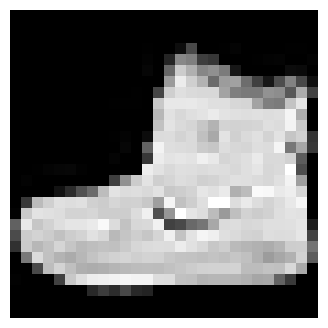

In [132]:
show_image(images[0], figsize=(4, 4))

<Axes: >

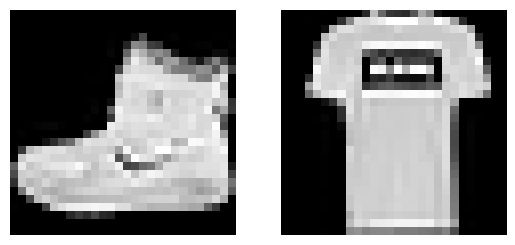

In [133]:
fig, axs = plt.subplots(1, 2)  # axs now has 2 plots
show_image(images[0], axs[0])
show_image(images[1], axs[1])

In [34]:
# |export


@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows: int = 1,  # Number of rows in returned axes grid
    ncols: int = 1,  # Number of columns in returned axes grid
    figsize: tuple = None,  # Width, height in inches of the returned figure
    imsize: int = 3,  # Size (in inches) of images that will be displayed in the returned figure
    suptitle: str = None,  # Title to be set to returned figure
    **kwargs
):
    """A figure and set of subplots to display images of `imsize` inches"""
    if figsize is None:
        figsize = (ncols * imsize, nrows * imsize)

    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)

    if suptitle is not None:
        fig.suptitle(suptitle)

    if nrows * ncols == 1:
        ax = np.array([ax])

    return fig, ax

In [123]:
from nbdev.showdoc import show_doc

show_doc(subplots)

---

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                width_ratios=None, height_ratios=None, subplot_kw=None,
>                gridspec_kw=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| width_ratios | NoneType | None |  |
| height_ratios | NoneType | None |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |

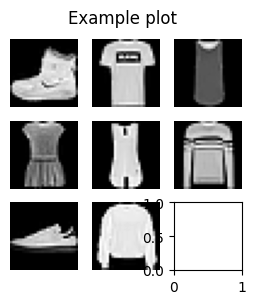

In [127]:
fig, axs = subplots(3, 3, imsize=1, suptitle="Example plot")

for ax, img in zip(axs.flat, images[:8]):
    show_image(img, ax)

In [35]:
# |export


@fc.delegates(subplots)
def get_grid(
    n: int,  # Number of axes
    nrows: int = None,  # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols: int = None,  # Number of columns, defaulting to `ceil(n/rows)`
    title: str = None,  # If passed, title set to the figure
    weight: str = "bold",  # Title font weight
    size: int = 14,  # Title font size
    **kwargs,
):
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows:
        ncols = ncols or int(np.ceil(n / nrows))
    elif ncols:
        nrows = nrows or int(np.ceil(n / ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n / nrows))

    print(nrows, ncols)

    fig, axs = subplots(nrows, ncols, **kwargs)

    for i in range(n, nrows * ncols):
        axs.flat[i].set_axis_off()

    if title is not None:
        fig.suptitle(title, weight=weight, size=size)

    return fig, axs

3 3


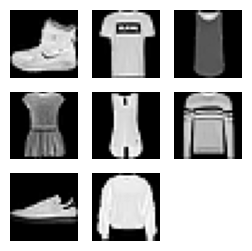

In [155]:
fig, axs = get_grid(8, nrows=3, imsize=1)

for ax, img in zip(axs.flat, images[:8]):
    show_image(img, ax)

In [36]:
# |export


@fc.delegates(subplots)
def show_images(
    ims: list,  # Images to show
    nrows: int | None = None,  # Number of rows in grid
    ncols: int | None = None,  # Number of columns in grid (auto-calculated if None)
    titles: list | None = None,  # Optional list of titles for each image
    **kwargs
):
    """ "Show all images `ims` as subplots with `rows` using `titles`"""

    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat

    for im, t, ax in zip_longest(ims, titles or [], axs):
        show_image(im, ax=ax, title=t)

2 4


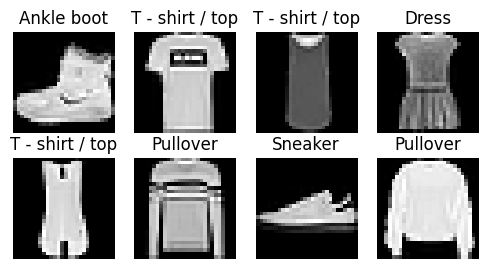

In [166]:
labels = batch["label"][:8]
titles = train_ds.features["label"].int2str(labels)

show_images(images[:8], imsize=1.5, titles=titles)